# Ribosome Stalling Sites

First, create the infrastructre for the analysis.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
%%capture
import sys
sys.path.insert(0, '/home/raf_pc/Kemal/RiboSeqAnalysis')
from infrastructure.main import *

# Working environment
temp_repo_dir = "/home/raf_pc/Kemal/Temp"
data_repo_dir = "/home/raf_pc/Kemal/Data"

# SAM files for ribosome stalling data and coco assembly data
spt = [os.path.join(data_repo_dir, "Sixtymers", i) for i in ["60mer_TT1.sam", "60mer_TT2.sam"]]
sps = [os.path.join(data_repo_dir, "Sixtymers", i) for i in ["60mer_Rep1.sam", "60mer_Rep2.sam", "60mer_NoPK.sam"]]
coco_d = [os.path.join(data_repo_dir, "Coco", i) for i in ["Dis1.sam", "Dis2.sam"]]
coco_m = [os.path.join(data_repo_dir, "Coco", i) for i in ["Mono1.sam", "Mono2.sam"]]

# Exculude the gene below because it has over-expression problem.
exclude_genes = ["ENSG00000160789"]

# Create the infrastructure object
I = Infrastructre(temp_repo_dir, exclude_genes=exclude_genes, sixtymers=[spt, sps], coco=[coco_m, coco_d])

### Distribution of RPKM values in imported data

Let's check the relationship between two riboseq data, ideally control vs experiment pairs like sixtymers versus translatome.
<br>
Note: To draw loglog plot, zero values were removed.

In [3]:
import statsmodels.api as sm
from scipy import stats 

def compare_two_riboseq(arr1, arr2, narr1, narr2, general): # translatome, sixtymers:
    # Plot the result as histograms
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
    plt.yscale('log')
    plt.suptitle(f"RPKM distribution of {general}")
    for i, (k, j) in enumerate(zip([arr1, arr2,], [narr1, narr2])):
        axes[i].hist(k, density=True, bins=50);
        axes[i].set_ylabel('Probability')
        axes[i].set_xlabel(f'{j} RPKM')
    plt.show()

    # Fit the linear line to the loglog
    non_zero = np.intersect1d(np.nonzero(arr1), np.nonzero(arr2))
    arr1_log = np.log10(arr1[non_zero])
    arr2_log = np.log10(arr2[non_zero])
    results = sm.OLS(arr2_log, sm.add_constant(arr1_log)).fit()
    x_data_log = np.linspace(arr1_log.min(), arr1_log.max(), 1000)
    y_data_log = x_data_log * results.params[1] + results.params[0]

    # Plot the result
    fig, ax = plt.subplots(figsize=(7, 7))
    plt.xlabel(f"{narr1} RPKM (x)")
    plt.ylabel(f"{narr2} RPKM (y)")
    plt.xscale('log')
    plt.yscale('log')
    ax.scatter(x=arr1[non_zero], y=arr2[non_zero], marker='.', edgecolors='none')
    ax.plot(10**x_data_log, 10**y_data_log, color="black")
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.25)
    textstr = '\n'.join((
        r'$log_{10}(y)=log_{10}(x)*%.2f + %.2f$' % (results.params[1], results.params[0]),
        r'$y=x^{%.2f}*10^{%.2f}$' % (results.params[1], results.params[0]),
        r'$R^2=%.2f$' % (results.rsquared,),
        ))
    ax.text(0.025, 0.975, textstr, transform=ax.transAxes, verticalalignment='top', horizontalalignment="left", bbox=props, alpha=1)
    plt.show()
    
    # Check the correlation between RPKM values of translatome and experiment for sixytmer data

    corr_nonzero = stats.pearsonr(tt_rpkms[non_zero], ex_rpkms[non_zero])
    corr_all = stats.pearsonr(tt_rpkms, ex_rpkms)

    print("Pearson correlation (only nonzero): %.4f, where p=%.2f" % (corr_nonzero[0], corr_nonzero[1]))
    print("Pearson correlation (all): %.4f, where p=%.2f" % (corr_all[0], corr_all[1]))

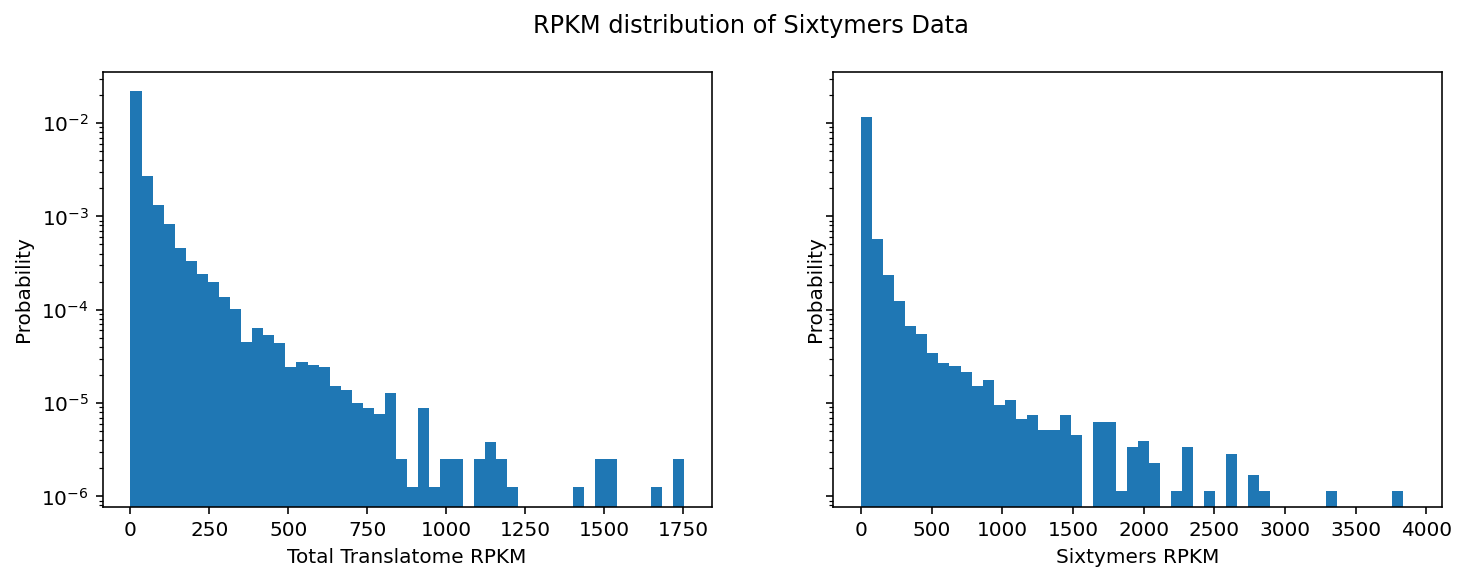

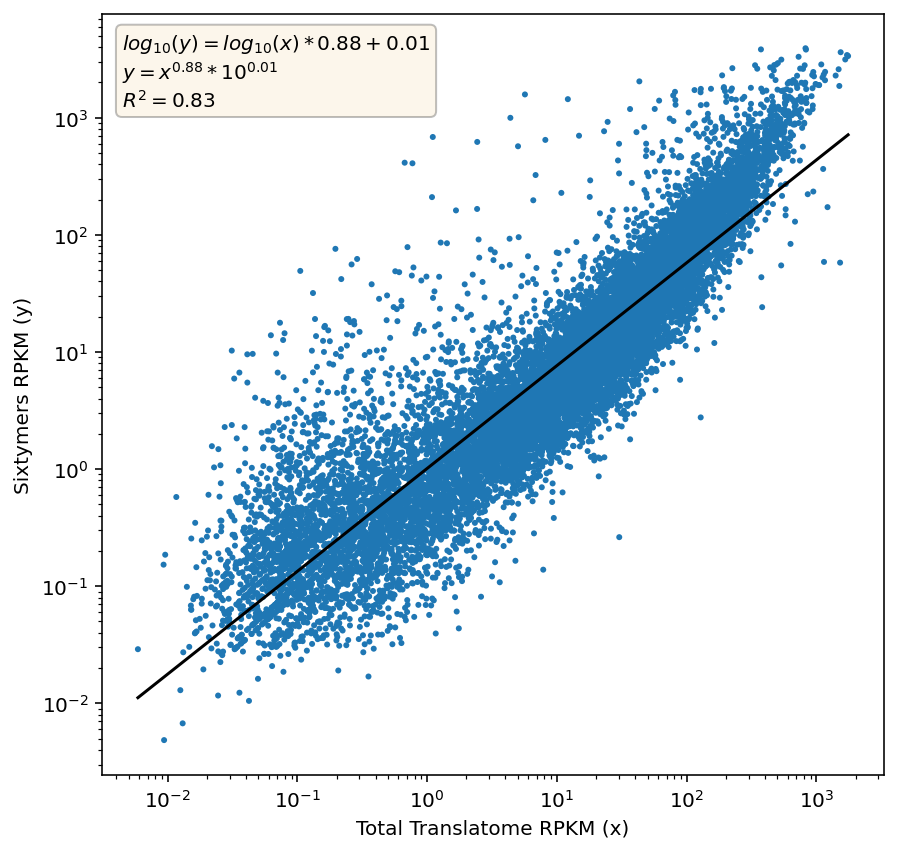

Pearson correlation (only nonzero): 0.7761, where p=0.00
Pearson correlation (all): 0.7807, where p=0.00


In [4]:
# Get the total translatome and experiment RPKM values for sixytmer data.
tt_rpkms = np.array([I.riboseq_sixtymers.translatome.calculate_rpkm_genes(g) for g in I.gene_list])
ex_rpkms = np.array([I.riboseq_sixtymers.experiment.calculate_rpkm_genes(g) for g in I.gene_list])
compare_two_riboseq(tt_rpkms, ex_rpkms, "Total Translatome", "Sixtymers", "Sixtymers Data")


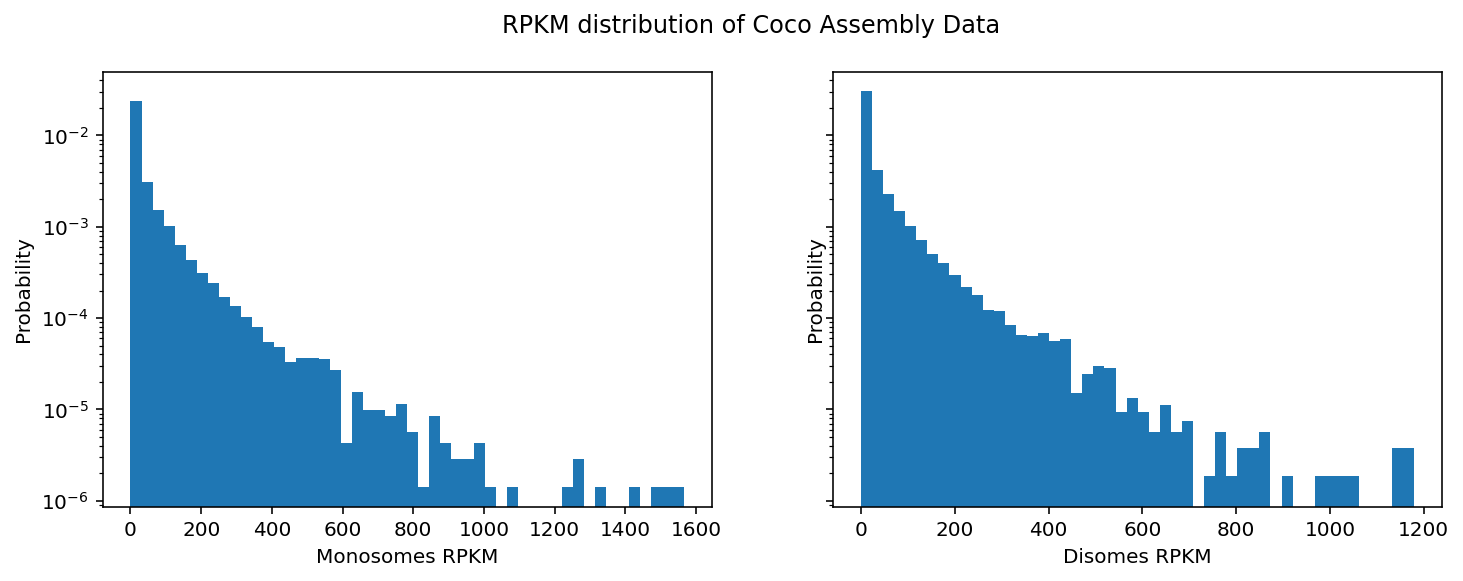

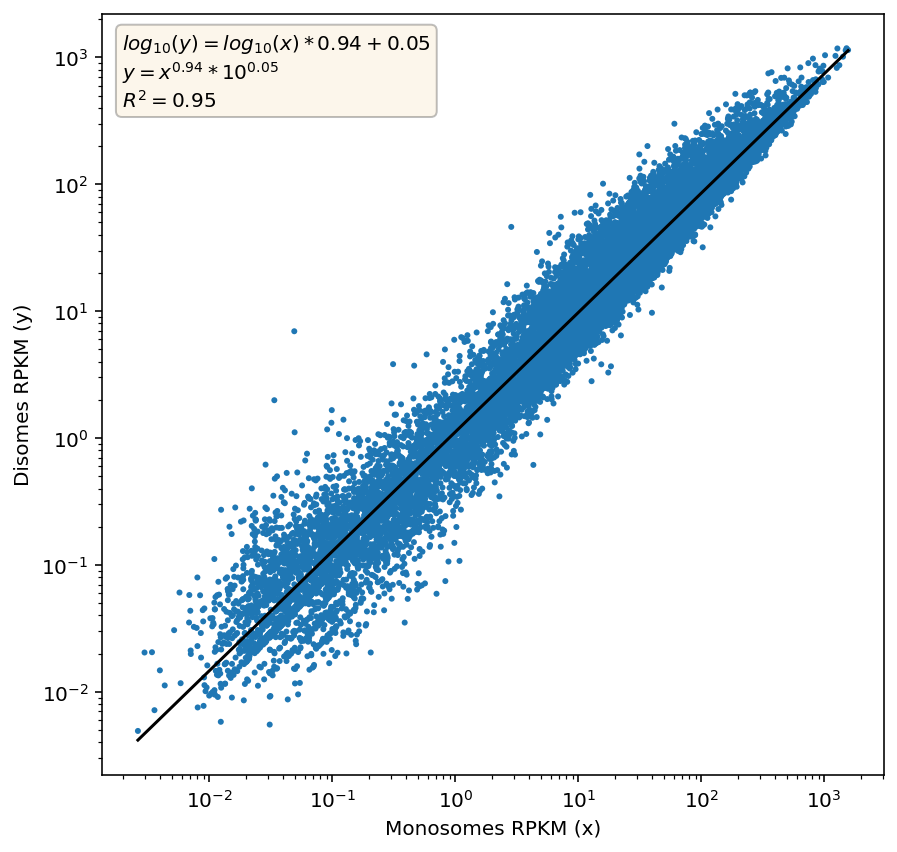

Pearson correlation (only nonzero): 0.9388, where p=0.00
Pearson correlation (all): 0.9438, where p=0.00


In [5]:
# Get the monosomes and disomes RPKM values for coco assembly data.
tt_rpkms = np.array([I.riboseq_coco.translatome.calculate_rpkm_genes(g) for g in I.gene_list])
ex_rpkms = np.array([I.riboseq_coco.experiment.calculate_rpkm_genes(g) for g in I.gene_list])
compare_two_riboseq(tt_rpkms, ex_rpkms, "Monosomes", "Disomes", "Coco Assembly Data")

In [11]:
I.riboseq_coco.translatome.total_assigned

array([10364161., 11246737.])

In [10]:
I.riboseq_sixtymers.translatome.total_assigned

array([5373910., 6294791.])

In [ ]:
# Check the correlation between RPKM values of translatome and experiment for coco assembly data


In [ ]:
from scipy.ndimage import gaussian_filter1d

def inecik(gene_id):
    land = self.experiment.calculate_rpm_positions(gene_id)
    #land = smooth(land, window_len=15)
    land_s1=gaussian_filter1d(land, sigma=10)
    peaks = find_peaks(land_s1)[0]
    try:
        land_t = land_s1 > threshold_li(land_s1[peaks], nbins=int(len(peaks) / 3))
    except ValueError:
        land_t = []
    return land_s1, np.argwhere(land_t)

In [ ]:
plt.plot(land/land.max(), color="gray", alpha=0.5)
land_s1=gaussian_filter1d(land, sigma=15)
plt.plot(land_s1/land_s1.max(), color="blue", alpha=1)
#plt.plot(land_t, color="red", alpha=1)
plt.show()

In [ ]:
from scipy.signal.signaltools import wiener
from scipy.signal import savgol_filter, find_peaks, peak_widths


In [ ]:
# todo: a jupyter notebook aç
# - distribution of stallings
# - dist of tt
# - birbirlerine oranı'nın grafiği: correlasyon ve oranların distribution'u
# ne kadar base, ssig ve dsig var

# normalize'ı düzelt



# posizyonlar ne oranda correle oluyor: tt_stalling vs monosome
# genlerin toplam ne oranda correle oluyor: 




# tt'nin average rpkm'i kaç, bir threshold belirle, altındaki genleri disregard et

# önce fixed gaussian'la şeyap
# sonra normalize
# bütün genomdeaki bütün peak'in average genişliği ve uzunluğu kaç
# bundan significantly sapan peak'leri peak diye seç, ya da threshold belirle istatistiki olarak.
# aynısını gen içerisinde peak'leri seçerek de yap